# Segmentation des cellules

La méthode de segmentation qui suit repose sur l'extraction des couleurs.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import cv2
from yawbcc.datasets import load_barcelona_wbc

meta = load_barcelona_wbc()
meta.head()

,image,group,label,width,height,path
0,MO_322276.jpg,MONOCYTE,MO,360,363,/home/damien/yawbcc_data/barcelona/monocyte/MO...
1,MO_542415.jpg,MONOCYTE,MO,360,363,/home/damien/yawbcc_data/barcelona/monocyte/MO...
2,MO_657991.jpg,MONOCYTE,MO,360,363,/home/damien/yawbcc_data/barcelona/monocyte/MO...
3,MO_372163.jpg,MONOCYTE,MO,360,363,/home/damien/yawbcc_data/barcelona/monocyte/MO...
4,MO_237869.jpg,MONOCYTE,MO,360,363,/home/damien/yawbcc_data/barcelona/monocyte/MO...


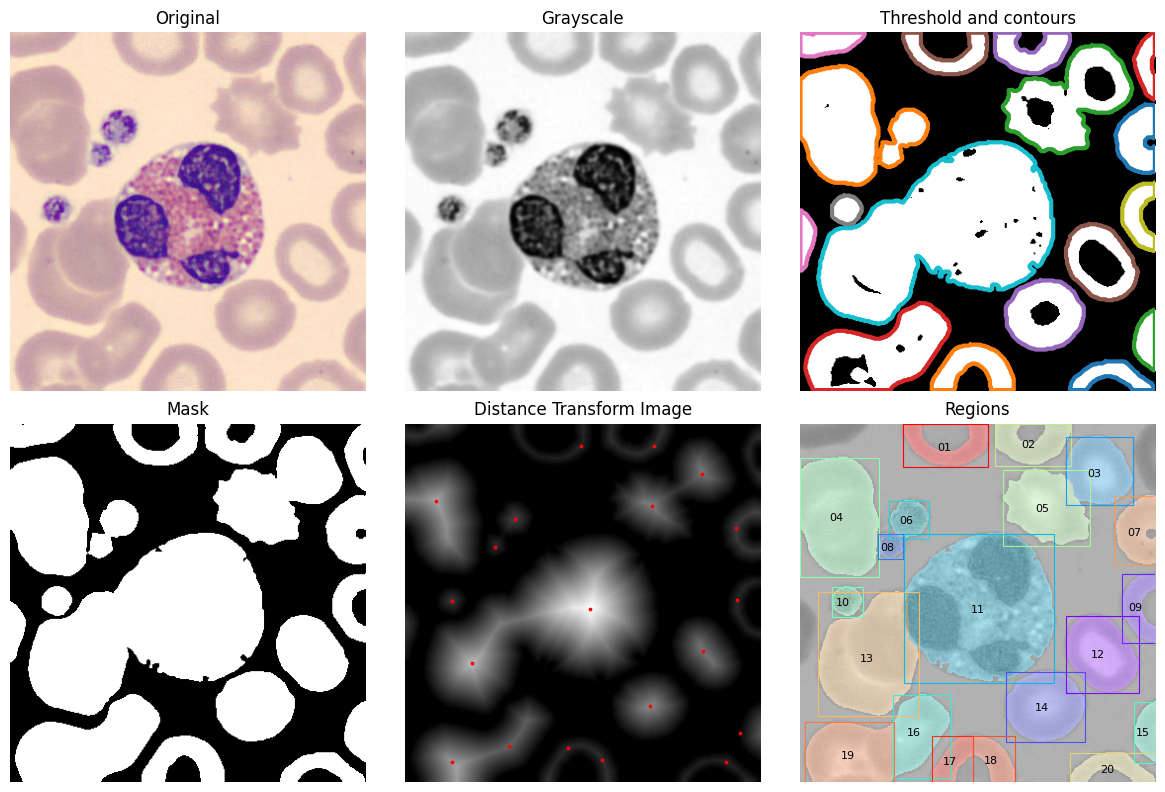

In [2]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label, regionprops, moments
from skimage.color import label2rgb
from skimage.filters import unsharp_mask
import matplotlib.patches as mpatches


def imshow(ax, img, title='', cmap=None):
    cmap = cmap if cmap else 'gray' if len(img.shape) == 2 else None
    ax.imshow(img, cmap=cmap)
    ax.set_title(title)
    ax.axis('off')
    return ax

# Charge l'image et la transforme en niveau de gris
filename = str(meta.loc[meta['image'] == 'EO_45684.jpg', 'path'].squeeze())
img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
rgb = (img * gray.mean() / img.mean(axis=(0, 1))).astype(np.uint8)

# Trouve les contours extérieurs des cellules
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)# | cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Crée un masque en remplissant les contours
mask = cv2.drawContours(np.zeros(thresh.shape, np.uint8), contours, -1, 255, cv2.FILLED)

# Distance entre chaque pixel blanc et le pixel noir le plus proche
dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)

# Trouve les maximas locaux (environ le nombre de cellules de l'image)
coords = peak_local_max(dist, min_distance=20, labels=mask)

# Crée les marqueurs à partir des coordonnées des maximas
markers = np.zeros(dist.shape, dtype=np.uint8)
markers[tuple(coords.T)] = 1
markers = label(markers)

# Algorithme watershed
labels = watershed(-dist, markers, mask=mask)

# Extrait le leucocyte par minimisation entre la distance du centre de la cellule et du centre de l'image
cx, cy = dist.shape[1] // 2, dist.shape[0] // 2
wbc = min(regionprops(labels), key=lambda x: np.sqrt((cx-x.centroid[1])**2 + (cy-x.centroid[0])**2))

###################
### Draw figure ###
###################
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

cmap = plt.cm.get_cmap('rainbow')(np.linspace(0, 1, len(coords)))
np.random.seed(2022)
np.random.shuffle(cmap)
color1 = label2rgb(labels, colors=cmap, image=img)

imshow(axs[0, 0], img, 'Original')
imshow(axs[0, 1], gray, 'Grayscale')
imshow(axs[0, 2], thresh, 'Threshold and contours')
for c in contours:
    axs[0, 2].plot(*c.squeeze().T, lw=3)
imshow(axs[1, 0], mask, 'Mask')
imshow(axs[1, 1], dist, 'Distance Transform Image')
axs[1, 1].scatter(*coords.T[::-1], c='red', s=3)
imshow(axs[1, 2], color1, 'Regions')

for region in regionprops(labels):
    y0, x0, y1, x1 = region.bbox
    cx, cy = (x0 + x1) / 2, (y0 + y1) / 2
    w = x1 - x0
    h = y1 - y0
    c = (int(region.centroid[1]), int(region.centroid[0]))
    rect = mpatches.Rectangle((x0, y0), w, h, fill=False, fc='white', ec=cmap[region.label-1], lw=0.8)
    axs[1, 2].add_patch(rect)
    axs[1, 2].text(c[0]-10, c[1]+5, f'{region.label:02}', fontdict={'size': 8})
plt.tight_layout()

## 1. Extraction de la cellule

### a. Première méthode

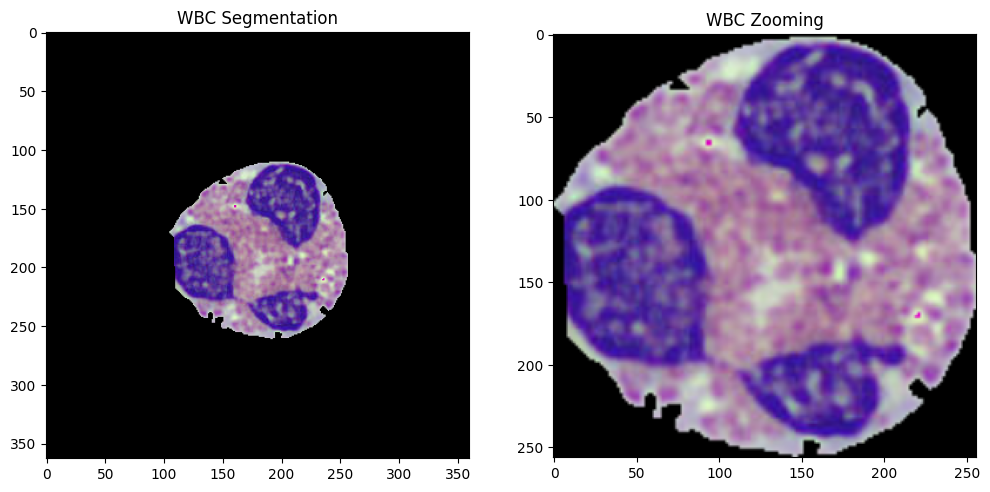

In [3]:
y0, x0, y1, x1 = wbc.bbox
l = max(x1 - x0, y1 - y0)
r = (l // 2) + (l % 2)
cx, cy = (x0 + x1) // 2, (y0 + y1) // 2

cell1 = cv2.bitwise_and(rgb, rgb, mask=(labels==wbc.label).astype(np.uint8))
cell2 = cv2.resize(cell1[cy-r:cy+r, cx-r:cx+r], (256, 256))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(cell1, cmap='gray'); ax1.set_title('WBC Segmentation')
ax2.imshow(cell2, cmap='gray'); ax2.set_title('WBC Zooming')
plt.show()

### b. Deuxième méthode

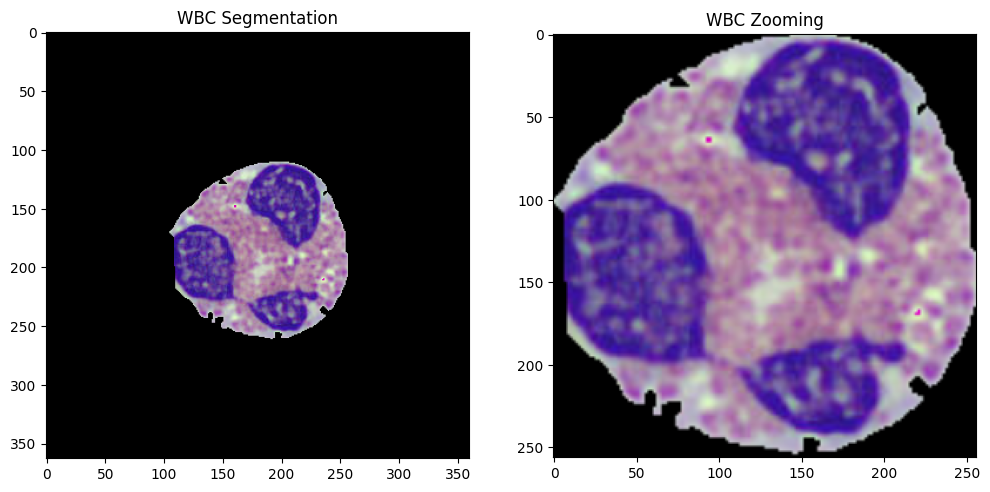

In [4]:
y0, x0, y1, x1 = wbc.bbox
w, h = x1 - x0, y1 - y0
l = max(w, h)
cx, cy = (l - w) // 2, (l - h) // 2

rgb = (img * gray.mean() / img.mean(axis=(0, 1))).astype(np.uint8)
rgb = cv2.bitwise_and(rgb, rgb, mask=(labels==wbc.label).astype(np.uint8))
cell = np.zeros((l, l, 3), dtype=np.uint8)
cell[cy:cy+h, cx:cx+w] = rgb[y0:y1, x0:x1]
cell = cv2.resize(cell, (256, 256))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(rgb, cmap='gray'); ax1.set_title('WBC Segmentation')
ax2.imshow(cell, cmap='gray'); ax2.set_title('WBC Zooming')
plt.show()

### c. Extraction par lot

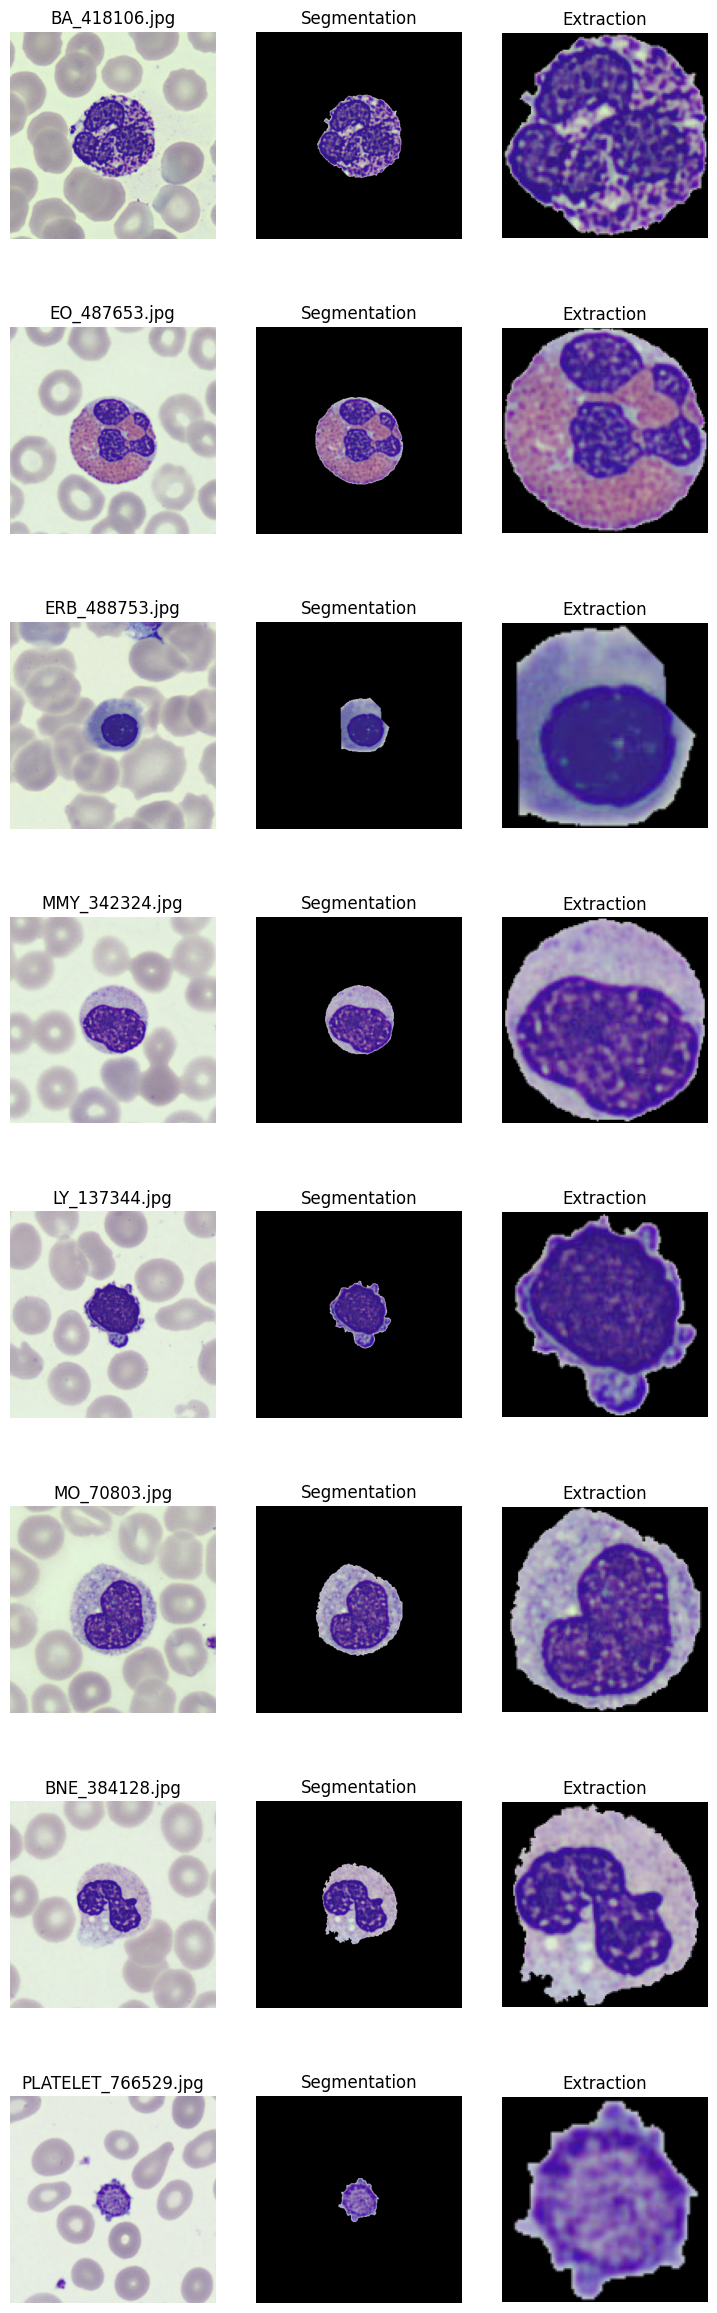

In [5]:
def segment_wbc(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Trouve les contours extérieurs des cellules
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)# | cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Crée un masque en remplissant les contours
    mask = cv2.drawContours(np.zeros(thresh.shape, np.uint8), contours, -1, 255, cv2.FILLED)

    # Distance entre chaque pixel blanc et le pixel noir le plus proche
    dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)

    # Trouve les maximas locaux (environ le nombre de cellules de l'image)
    coords = peak_local_max(dist, min_distance=10, labels=mask)

    # Crée les marqueurs à partir des coordonnées des maximas
    markers = np.zeros(dist.shape, dtype=np.uint8)
    markers[tuple(coords.T)] = 1
    markers = markers.cumsum().reshape(markers.shape) * markers

    # Algorithme watershed
    labels = watershed(-dist, markers, mask=mask)

    # Extrait le leucocyte par minimisation entre la distance du centre de la cellule et du centre de l'image
    cx, cy = dist.shape[1] // 2, dist.shape[0] // 2
    wbc = min(regionprops(labels), key=lambda x: np.sqrt((cx-x.centroid[1])**2 + (cy-x.centroid[0])**2))
    
    return (wbc, (labels==wbc.label).astype(np.uint8))


df = meta.groupby('group').sample(n=1, random_state=2022)
fig, axs = plt.subplots(len(df), 3, figsize=(9, 30))
for i, row in enumerate(df.itertuples()):
    img = cv2.cvtColor(cv2.imread(row.path), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    rgb = (img * gray.mean() / img.mean(axis=(0, 1))).astype(np.uint8)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    wbc, mask = segment_wbc(img)
    y0, x0, y1, x1 = wbc.bbox
    l = max(x1 - x0, y1 - y0)
    r = (l // 2) + (l % 2) + 1
    cx, cy = (x0 + x1) // 2, (y0 + y1) // 2

    cell1 = cv2.bitwise_and(rgb, rgb, mask=mask)
    cell2 = cv2.resize(cell1[cy-r:cy+r, cx-r:cx+r], (128, 128))

    imshow(axs[i, 0], rgb, row.image)
    imshow(axs[i, 1], cell1, 'Segmentation')
    imshow(axs[i, 2], cell2, 'Extraction')

### d. Dessin du contour

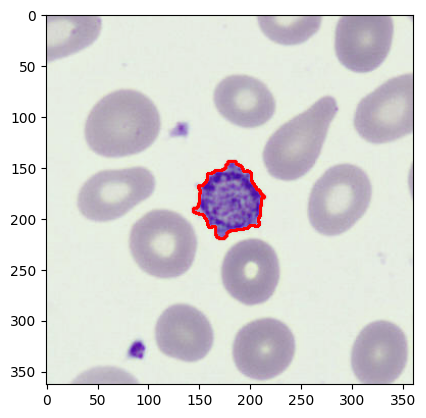

In [6]:
contour = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
final = cv2.drawContours(rgb, contour, -1, (255, 0, 0), 2)
plt.imshow(final)